In [1]:
!pip install plotly

In [2]:
import plotly.express as px

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import random


from random import choices
from scipy import stats
from tqdm.notebook import tqdm

In [4]:
from jupyter_utils import mean_std, display_test, display_group_test, scatter_annotate, show_corrtest_mask_corr
from ortogonolize_utils import draw_scatter, draw_corrected_scatter
from ortogonolize_utils import compute_coefficient, compute_ortogonolized_coefficient, compute_ortogonolized_logit

In [5]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [6]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/'

# Patients

In [7]:
df = pd.read_excel(PATH +'NAP/GR_all6M_MPP.xlsx', index_col=0, na_values=[' ', '', -99.0])
df = df[df.index.notnull()].drop(columns=['Unnamed: 98', 'Unnamed: 99'])

In [8]:
# total positve ftd - saps34; total alogia - sans12
# sex_nr - female = 1, male = 0
# ausja_bl = education years at baseline (i.e. 6 months before the NET interview)
# pa - panss

# df.columns

In [9]:
# print(*enumerate('PANSS P1	PANSS P2	PANSS P3	PANSS P4	PANSS P5	PANSS P6	PANSS P7	PANSS N1	PANSS N2	PANSS N3	PANSS N4	PANSS N5	PANSS N6	PANSS N7	PANSS O1	PANSS O2	PANSS O3	PANSS O4	PANSS O5	PANSS O6	PANSS O7	PANSS O8	PANSS 09	PANSS O10	PANSS O11	PANSS O12	PANSS O13	PANSS O14	PANSS O15	PANSS 016'.split('\t')))

In [10]:
df['panss_pos'] = df[['pa_01', 'pa_02', 'pa_03', 'pa_04', 'pa_05', 'pa_06', 'pa_07']].sum(axis=1)
df['panss_neg'] = df[['pa_08', 'pa_09', 'pa_10', 'pa_11', 'pa_12', 'pa_13', 'pa_14', 'pa_15']].sum(axis=1)
df['panss_o'] = df[['pa_16', 'pa_17', 'pa_18', 'pa_19', 'pa_20', 'pa_21', 'pa_22', 'pa_23', 'pa_24', 'pa_25', 'pa_26', 'pa_27', 'pa_28', 'pa_29', 'pa_30']].sum(axis=1)
df['panss_total'] = df[['panss_pos', 'panss_neg', 'panss_o']].sum(axis=1)
df['saps_total'] = df[['saps1', 'saps2', 'saps3', 'saps4', 'saps5', 'saps6', 'saps7', 'saps8', 'saps9', 'saps10', 'saps11', 'saps12', 'saps13', 'saps14', 'saps15', 'saps16', 'saps17', 'saps18', 'saps19', 'saps20', 'saps21', 'saps22', 'saps23', 'saps24', 'saps25', 'saps26', 'saps27', 'saps28', 'saps29', 'saps30', 'saps31', 'saps32', 'saps33', 'saps34', 'saps35']].sum(axis=1)
df['sans_total'] =  df[['sans1', 'sans2', 'sans3', 'sans4', 'sans5', 'sans6', 'sans7', 'sans8', 'sans9', 'sans10', 'sans11', 'sans12', 'sans13', 'sans14', 'sans15', 'sans16', 'sans17', 'sans18', 'sans19', 'sans20', 'sans21', 'sans22', 'sans23', 'sans24']].sum(axis=1)

#### Filter out only the patients there are transcripts for

In [11]:
# df.index

In [12]:
df.index.rename('ID', inplace=True)

In [13]:
res = pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_patients.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [14]:
res.dropna(how='all', inplace=True)

In [15]:
idxs = sorted([x.replace('_6M_manual_c', '') for x in res.index])
idxs = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in idxs]

In [16]:
res.index = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in [x.replace('_6M_manual_c', '') for x in res.index]]
res.index.rename('ID', inplace=True)

In [17]:
set(idxs).difference(set(df.index))

set()

In [18]:
df = df.loc[idxs]

#### Look up descriptitve stats

In [19]:
cols = ['age', 'sex_nr', 'Bildungsjahre', 'IQ_kristallin', 'saps34', 'saps_total', 'sans_total', 'sans12', 'panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [20]:
df[cols].count()

age              59
sex_nr           59
Bildungsjahre    59
IQ_kristallin    58
saps34           59
saps_total       59
sans_total       59
sans12           59
panss_pos        59
panss_neg        59
panss_o          59
panss_total      59
dtype: int64

In [21]:
mean_std(df, cols)

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
value,39.49 (11.11),0.41 (0.5),14.62 (2.95),105.16 (15.65),1.03 (1.05),16.81 (16.7),27.73 (20.35),0.92 (1.19),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)


In [22]:
mean_std(df, cols, 'sex_nr')

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
sex_nr,,,,,,,,,,,,
0.0,37.29 (10.12),0.0 (0.0),14.54 (3.11),107.0 (12.7),1.03 (1.04),18.57 (16.7),28.63 (21.23),0.94 (1.24),13.37 (5.61),17.14 (6.6),28.64 (7.63),59.15 (16.99)
1.0,42.71 (11.9),1.0 (0.0),14.73 (2.78),102.35 (19.28),1.04 (1.08),14.25 (16.71),26.42 (19.37),0.88 (1.15),11.62 (5.22),16.42 (5.17),26.45 (7.3),54.5 (14.84)


In [23]:
df.groupby('sex_nr').count()

,Messzeitpunkt,age,Bildungsjahre,ausja_bl,IQ_kristallin,saps1,saps2,saps3,saps4,saps5,...,pa_29,pa_30,pa_VT,pa_R,panss_pos,panss_neg,panss_o,panss_total,saps_total,sans_total
sex_nr,,,,,,,,,,,,,,,,,,,,,
0.0,35,35,35,34,35,32,34,35,35,35,...,35,35,33,32,35,35,35,35,35,35
1.0,24,24,24,23,23,23,23,24,24,24,...,24,24,22,22,24,24,24,24,24,24


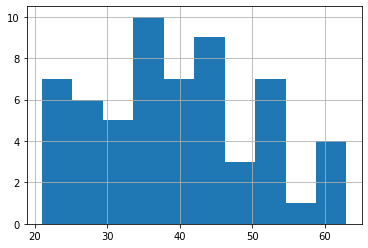

In [24]:
df.age.hist();

# Healthy controls

In [25]:
df_hc = pd.read_csv(PATH + 'HC/NET_HC.csv', index_col=0, na_values=[' ', ''])

In [26]:
df_hc.columns

Index(['age', 'sex_nr', 'Bildungsjahre'], dtype='object')

#### Look up descriptive stats

In [27]:
df_hc.count()

age              20
sex_nr           20
Bildungsjahre    19
dtype: int64

In [28]:
mean_std(df_hc, ['age', 'Bildungsjahre'])

,age,Bildungsjahre
value,43.85 (13.29),15.5 (2.78)


In [29]:
mean_std(df_hc, ['age', 'Bildungsjahre'], 'sex_nr')

,age,Bildungsjahre
sex_nr,,
0.0,42.27 (12.24),15.7 (3.13)
1.0,45.78 (14.99),15.28 (2.51)


In [30]:
df_hc.groupby('sex_nr').count()

,age,Bildungsjahre
sex_nr,,
0.0,11,10
1.0,9,9


In [31]:
# df_hc.index

#### Check that all the transcripts are availble

In [32]:
res_hc =  pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_HC.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [33]:
idxs_HC = sorted([x.replace('_c', '').replace('NET_', '')  for x in res_hc.index])

In [34]:
set(idxs_HC).difference(set(df_hc.index))

set()

In [35]:
df_hc = df_hc.loc[idxs_HC]

In [36]:
df_hc.index.rename('ID', inplace=True)

In [37]:
res_hc.index = [x.replace('_c', '').replace('NET_', '')  for x in res_hc.index]
res_hc.index.rename('ID', inplace=True)

In [38]:
merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')
corr_hc = merged_hc.corr()

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_17740/1853110338.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')


#### Fill NA in syntactic (percentage of unused POS should be zero, not NA)

In [39]:
cols_LM = [col for col in merged_hc if col[0] == 'LM']
cols_synt = [col for col in merged_hc if col[0] == 'syntactic']
cols_lex = [col for col in merged_hc if col[0] == 'lexical']
cols_graph = [col for col in merged_hc if col[0] == 'graph']

In [40]:
s = merged_hc[cols_synt].isna().any()
s[s].index

Index([('syntactic', 'INTJ'), ('syntactic', 'NUM'), ('syntactic', 'X')], dtype='object')

In [41]:
# merged_hc[s[s].index][merged_hc[cols_synt].isna().any(axis=1)]

In [42]:
merged_hc[s[s].index] = merged_hc[s[s].index].fillna(0.0)

### Analyze the effects of age in healthy controls

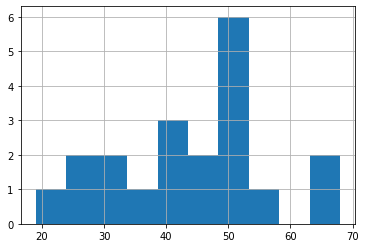

In [43]:
df_hc.age.hist();

In [44]:
df_hc[df_hc.age > 60]

,age,sex_nr,Bildungsjahre
ID,,,
KG_010,65.0,0.0,18.0
KG_015,68.0,1.0,16.0


In [45]:
corr_hc[abs(corr_hc['age']) > 0.3]['age']

age                    1.000000
(graph, degree_std)    0.315543
(syntactic, INTJ)     -0.330995
(syntactic, PRON)      0.359937
(syntactic, VERB)      0.327677
Name: age, dtype: float64

In [46]:
corr_hc[abs(corr_hc['age']) > 0.3].index

Index([                  'age', ('graph', 'degree_std'),
         ('syntactic', 'INTJ'),   ('syntactic', 'PRON'),
         ('syntactic', 'VERB')],
      dtype='object')

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


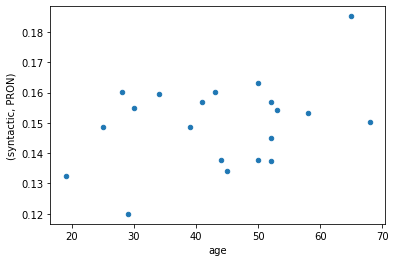

In [47]:
merged_hc.plot.scatter('age', ('syntactic', 'PRON'));

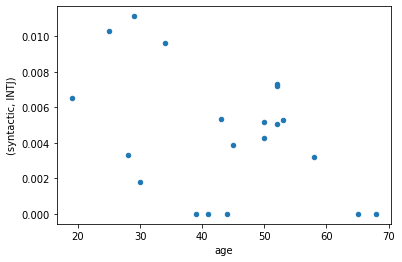

In [48]:
merged_hc.plot.scatter('age', ('syntactic', 'INTJ'));

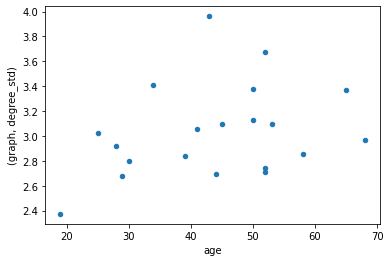

In [49]:
merged_hc.plot.scatter('age', ('graph', 'degree_std'));

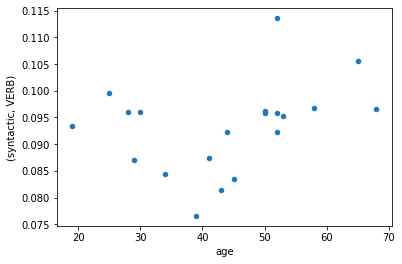

In [50]:
merged_hc.plot.scatter('age', ('syntactic', 'VERB'));

In [51]:
corr_hc[abs(corr_hc['age']) > 0.5].index

Index(['age'], dtype='object')

### Analyze the effects of education years in healthy controls

In [52]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.3].index

Index([               'Bildungsjahre',              ('LM', 'm_cgcoh'),
                     ('LM', 'm_gcoh'),               ('LM', 'm_lcoh'),
                     ('LM', 'm_scoh'),              ('LM', 'm_sporb'),
                      ('graph', 'L1'),                ('graph', 'L3'),
               ('lexical', 'n_words'),         ('syntactic', 'CCONJ'),
                 ('syntactic', 'DET'),           ('syntactic', 'NUM'),
               ('syntactic', 'PUNCT'),             ('syntactic', 'X'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'min_sent_len'),  ('syntactic', 'std_sent_len')],
      dtype='object')

In [53]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.5].index

Index(['Bildungsjahre', ('LM', 'm_scoh')], dtype='object')

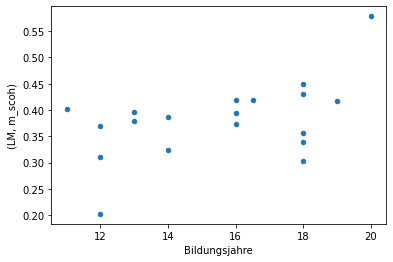

In [54]:
merged_hc.plot.scatter('Bildungsjahre', ('LM', 'm_scoh'));

In [55]:
stats.pearsonr(corr_hc['Bildungsjahre'], corr_hc[('syntactic', 'std_sent_len')])

PearsonRResult(statistic=0.6486436940204144, pvalue=8.197048800377838e-07)

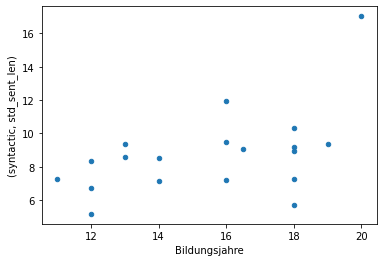

In [56]:
merged_hc.plot.scatter('Bildungsjahre', ('syntactic', 'std_sent_len'));

### Analyze the effects of sentence length in healthy controls

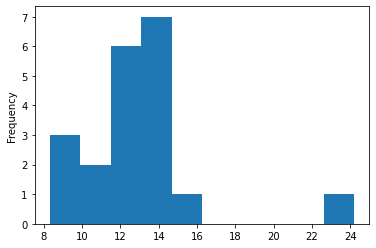

In [57]:
merged_hc[('syntactic', 'mean_sent_len')].plot.hist();

In [58]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.3].index

Index([               'Bildungsjahre',              ('LM', 'm_cgcoh'),
                     ('LM', 'm_gcoh'),               ('LM', 'm_lcoh'),
                     ('LM', 'm_scoh'),              ('LM', 'm_sporb'),
                      ('graph', 'L2'),                ('graph', 'L3'),
                     ('graph', 'LCC'),               ('graph', 'LSC'),
              ('graph', 'degree_std'),   ('graph', 'number_of_nodes'),
                   ('lexical', 'LTR'),           ('lexical', 'MALTR'),
               ('lexical', 'n_words'),           ('syntactic', 'ADV'),
                 ('syntactic', 'DET'),          ('syntactic', 'INTJ'),
                ('syntactic', 'PART'),         ('syntactic', 'PROPN'),
               ('syntactic', 'PUNCT'),             ('syntactic', 'X'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'std_sent_len')],
      dtype='object')

In [59]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.5].index

Index([             ('LM', 'm_cgcoh'),               ('LM', 'm_gcoh'),
                     ('LM', 'm_lcoh'),               ('LM', 'm_scoh'),
                    ('LM', 'm_sporb'),                ('graph', 'L2'),
              ('graph', 'degree_std'),         ('lexical', 'n_words'),
                 ('syntactic', 'DET'),          ('syntactic', 'INTJ'),
                ('syntactic', 'PART'),         ('syntactic', 'PUNCT'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'std_sent_len')],
      dtype='object')

In [60]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index

Index([             ('LM', 'm_cgcoh'),               ('LM', 'm_gcoh'),
                     ('LM', 'm_lcoh'),               ('LM', 'm_scoh'),
               ('syntactic', 'PUNCT'),  ('syntactic', 'max_sent_len'),
       ('syntactic', 'mean_sent_len'),  ('syntactic', 'std_sent_len')],
      dtype='object')

In [61]:
corr_hc.loc[corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index][('syntactic', 'mean_sent_len')].sort_values(key=lambda x: abs(x), ascending=False)

(syntactic, mean_sent_len)    1.000000
(syntactic, std_sent_len)     0.942301
(syntactic, PUNCT)           -0.918776
(LM, m_scoh)                  0.880554
(syntactic, max_sent_len)     0.864847
(LM, m_gcoh)                  0.845814
(LM, m_lcoh)                  0.843736
(LM, m_cgcoh)                 0.728550
Name: (syntactic, mean_sent_len), dtype: float64

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


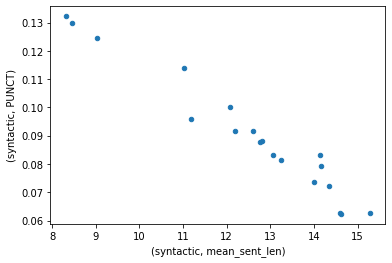

In [62]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('syntactic', 'PUNCT'));

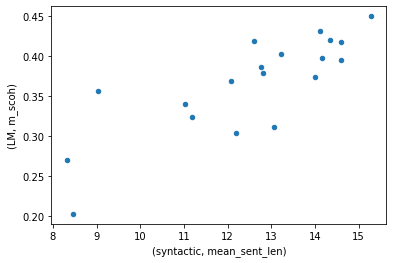

In [63]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_scoh'));

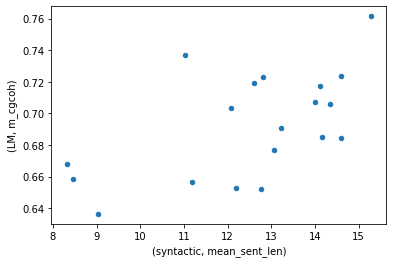

In [64]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'));

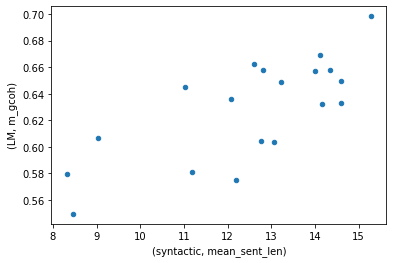

In [65]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_gcoh'));

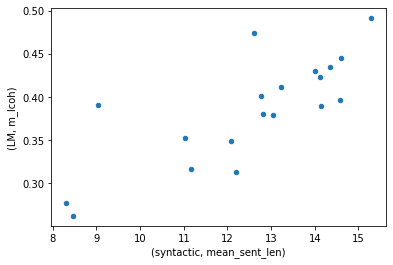

In [66]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_lcoh'));

# Merge control and patient data

In [67]:
df['group'] = 1
df_hc['group'] = 0
compare_groups = pd.concat([df[cols + ['group']], df_hc], axis=0)

In [68]:
compare_groups.groupby(['group']).count()

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
group,,,,,,,,,,,,
0,20,20,19,0,0,0,0,0,0,0,0,0
1,59,59,59,58,59,59,59,59,59,59,59,59


In [69]:
mean_std(compare_groups, ['age', 'Bildungsjahre'], 'group')


,age,Bildungsjahre
group,,
0,43.85 (13.29),15.5 (2.78)
1,39.49 (11.11),14.62 (2.95)


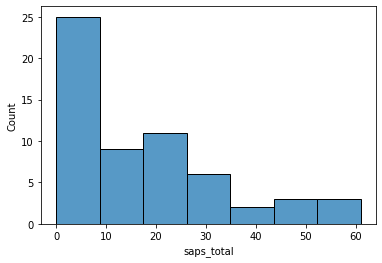

In [70]:
sns.histplot(compare_groups['saps_total']);

In [71]:
stats.ttest_ind(df['age'], df_hc['age']).pvalue

0.15339927043476997

In [72]:
stats.ttest_ind(df['Bildungsjahre'], df_hc['Bildungsjahre'], nan_policy='omit').pvalue

0.2552563345667248

In [73]:
combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_17740/1114475667.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')


### Fill NA in syntactic  (percentage of unused POS should be zero, not NA)

In [74]:
s = combined_data_averaged[cols_synt].isna().any()
s[s].index

Index([  ('syntactic', 'ADJ'),  ('syntactic', 'INTJ'),   ('syntactic', 'NUM'),
       ('syntactic', 'PROPN'),     ('syntactic', 'X')],
      dtype='object')

In [75]:
# combined_data_averaged[s[s].index][combined_data_averaged[cols_synt].isna().any(axis=1)]

In [76]:
combined_data_averaged[s[s].index] = combined_data_averaged[s[s].index].fillna(0.0)

In [77]:
# combined_data_averaged.columns

# Analyze the differences in control factors

In [78]:
clinical_cols = ['age',
 'Bildungsjahre',
 'IQ_kristallin',
 'saps34',
 'saps_total',
 'sans_total',
 'sans12',
 'panss_pos',
 'panss_neg',
 'panss_o',
 'panss_total']

In [79]:
cols_av = [('LM', 'm_lcoh'), ('LM', 'm_gcoh'), ('LM', 'm_cgcoh'), ('LM', 'm_scoh'), ('LM', 'm_sporb'), ('LM', 'm_bert_lcoh'), ('LM', 'm_bert_gcoh'), ('LM', 'm_bert_cgcoh'), ('LM', 'm_bert_scoh'),
           ('syntactic', 'n_sents'), ('syntactic', 'mean_sent_len'), ('syntactic', 'std_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'max_sent_len'), ('syntactic', 'SPACE'), ('syntactic', 'NOUN'), ('syntactic', 'X'), ('syntactic', 'PUNCT'), ('syntactic', 'VERB'), ('syntactic', 'ADV'), ('syntactic', 'ADP'), ('syntactic', 'ADJ'), ('syntactic', 'CCONJ'), ('syntactic', 'PRON'),
           ('syntactic', 'DET'), ('syntactic', 'AUX'), ('syntactic', 'PROPN'), ('syntactic', 'PART'), ('syntactic', 'SCONJ'), ('syntactic', 'INTJ'), ('syntactic', 'NUM'),
           ('lexical', 'n_words'), ('lexical', 'LTR'), ('lexical', 'MALTR'),
           ('graph', 'number_of_nodes'), ('graph', 'number_of_edges'), ('graph', 'PE'), ('graph', 'LCC'), ('graph', 'LSC'), ('graph', 'degree_average'), ('graph', 'degree_std'), ('graph', 'L1'), ('graph', 'L2'), ('graph', 'L3')
          ]

### Group difference for sex (absent)

In [80]:
a = 0.001
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, clinical_cols, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
s_t_sex

,t,p,sig,abs_t
age,1.920542,0.058492,False,1.920542
panss_pos,-1.208134,0.231984,False,1.208134
IQ_kristallin,-1.109496,0.271958,False,1.109496
panss_o,-1.099613,0.276123,False,1.099613
panss_total,-1.087868,0.281232,False,1.087868
saps_total,-0.976137,0.333121,False,0.976137
panss_neg,-0.451634,0.653247,False,0.451634
sans_total,-0.407092,0.685465,False,0.407092
sans12,-0.212810,0.832235,False,0.212810
Bildungsjahre,0.116948,0.907210,False,0.116948


In [81]:
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, cols_av, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
s_t_sex

,t,p,sig,abs_t
"('syntactic', 'PROPN')",-2.608761,0.010912,False,2.608761
"('graph', 'L2')",-2.281486,0.025283,False,2.281486
"('syntactic', 'ADV')",-1.908182,0.060095,False,1.908182
"('syntactic', 'SCONJ')",1.697308,0.093677,False,1.697308
"('graph', 'L3')",-1.199636,0.233959,False,1.199636
"('syntactic', 'NOUN')",1.197262,0.234877,False,1.197262
"('graph', 'degree_average')",-1.167001,0.246811,False,1.167001
"('syntactic', 'INTJ')",1.134376,0.260156,False,1.134376
"('graph', 'L1')",1.118428,0.266862,False,1.118428
"('syntactic', 'NUM')",1.035454,0.303698,False,1.035454


### Correlative difference for age, education years, and IQ (absent)

In [82]:
x, y = display_test(combined_data_averaged, cols_av, 'age', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.2].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
"(syntactic, VERB)",0.270178,0.016036,False,0.270178
"(syntactic, PRON)",0.219122,0.052355,False,0.219122
"(syntactic, INTJ)",-0.216837,0.054924,False,0.216837
"(syntactic, AUX)",0.202003,0.074216,False,0.202003


In [83]:
x, y = display_test(combined_data_averaged, cols_av, 'Bildungsjahre', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
"(syntactic, std_sent_len)",0.350334,0.001664,False,0.350334
"(syntactic, max_sent_len)",0.328066,0.003365,False,0.328066
"(syntactic, min_sent_len)",-0.325474,0.003641,False,0.325474
"(LM, m_bert_cgcoh)",-0.324344,0.003767,False,0.324344


In [84]:
x, y = display_test(combined_data_averaged, cols_av, 'IQ_kristallin', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
"(syntactic, INTJ)",-0.362102,0.00522,False,0.362102
"(syntactic, AUX)",0.334135,0.010364,False,0.334135
"(LM, m_sporb)",-0.311684,0.017233,False,0.311684


In [85]:
# normalized_combined_data_averaged = combined_data_averaged.copy()
# normalized_combined_data_averaged[cols_av] = (combined_data_averaged[cols_av]-combined_data_averaged[cols_av].min())/(combined_data_averaged[cols_av].max()-combined_data_averaged[cols_av].min())

In [86]:
combined_data_averaged.to_csv('averaged.csv')

# Analyze the metric performance

## Group difference & correlation with PANSS, SANS, and SAPS

In [87]:
a = 0.001
s_t, res_t = display_group_test(combined_data_averaged, cols_av, 'group', stats.ttest_ind, stat_name='t', alpha=a)

In [88]:
scales = ["saps_total", "sans_total", "panss", "panss_pos", "panss_neg", "panss_o"]
s_saps, r_saps = display_test(combined_data_averaged, cols_av, 'saps_total', stats.pearsonr, stat_name='r', alpha=a)
s_sans, r_sans = display_test(combined_data_averaged, cols_av, 'sans_total', stats.pearsonr, stat_name='r', alpha=a)
s_panss, r_panss = display_test(combined_data_averaged, cols_av, 'panss_total', stats.pearsonr, stat_name='r', alpha=a)
s_panss_pos, r_panss_pos = display_test(combined_data_averaged, cols_av, 'panss_pos', stats.pearsonr, stat_name='r', alpha=a)
s_panss_neg, r_panss_neg = display_test(combined_data_averaged, cols_av, 'panss_neg', stats.pearsonr, stat_name='r', alpha=a)
s_panss_o, r_panss_o = display_test(combined_data_averaged, cols_av, 'panss_o', stats.pearsonr, stat_name='r', alpha=a)
combined_corr = pd.concat([res_t, r_saps, r_sans, r_panss, r_panss_pos, r_panss_neg, r_panss_o], 
                     keys= ['t_test'] + scales, 
                     names=["scale"], axis=1)

In [89]:
combined_corr[('mean', 'abs_r')] = combined_corr[[(scale, 'abs_r') for scale in scales]].mean(axis=1)
mean_abs_r = combined_corr.pop(('mean', 'abs_r'))
combined_corr.insert(0, ('mean', 'abs_r'), mean_abs_r) 

In [90]:
# combined_corr[[(scale, 'abs_r') for scale in ["saps34", "sans12", "panss", "panss_pos", "panss_neg", "panss_o"]]].mean(axis=1)
t_p_n_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in ['sans_total', 'saps_total']], axis=1).mean(axis=1)
mean_rank = pd.concat([combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in scales], axis=1).mean(axis=1)
combined_corr.insert(1, ('mean', 'rank'), mean_rank) 
combined_corr.insert(2, ('mean', 'rank_abs'), mean_rank.rank()) 
combined_corr.insert(1, ('mean', 'tpn_rank'), t_p_n_rank) 
combined_corr.insert(2, ('mean', 'tpn_rank_abs'), t_p_n_rank.rank()) 

In [91]:
combined_corr.sort_values(('mean', 'rank'))[['mean', 't_test']].apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

## Analyze the relation between t-test and correlation with psychiatric scales

In [92]:
stats.pearsonr(combined_corr[('mean', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.415722078343508, pvalue=0.005008876782115987)

In [93]:
stats.pearsonr(combined_corr[('panss', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.3878133444311619, pvalue=0.009293027297775057)

In [94]:
stats.pearsonr(combined_corr[('saps_total', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=-0.07542180482293233, pvalue=0.6265537780945103)

In [95]:
stats.pearsonr(combined_corr[('panss_pos', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=-0.300970166350292, pvalue=0.047118490537846405)

In [96]:
stats.pearsonr(combined_corr[('sans_total', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.6097290858086345, pvalue=1.116139137311258e-05)

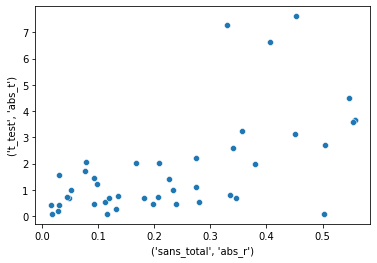

In [97]:
sns.scatterplot(x=combined_corr[('sans_total', 'abs_r')], y=combined_corr[('t_test', 'abs_t')]);

In [98]:
stats.pearsonr(combined_corr[('panss_neg', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.5925087625868244, pvalue=2.262225027369373e-05)

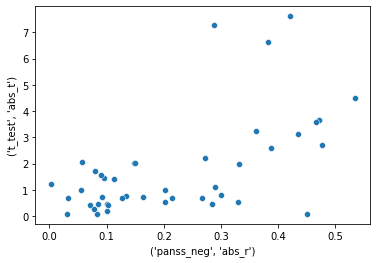

In [99]:
sns.scatterplot(x=combined_corr[('panss_neg', 'abs_r')], y=combined_corr[('t_test', 'abs_t')]);

In [100]:
# combined_corr.sort_values(('mean', 'tpn_rank_abs')).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

In [101]:
# combined_corr.sort_values(('t_test', 'abs_t'), ascending=False).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

In [102]:
# combined_corr.sort_values([('mean', 'abs_r')], ascending=False)

In [103]:
# combined_corr['t_test', 'abs_t']
# combined_corr['saps_total', 'abs_r']
# combined_corr['sans_total', 'abs_r']
# combined_corr['mean', 'tpn_rank']

In [104]:
# combined_corr['t_test', 'abs_t']

### Analyze interaction with length

In [105]:
corr_len_s, corr_len = display_test(combined_data_averaged, cols_av, ('syntactic', 'mean_sent_len'), stats.pearsonr, stat_name='r', alpha=a)

In [106]:
y = corr_len['abs_r']
tt_norm = (combined_corr['t_test', 'abs_t'] - combined_corr['t_test', 'abs_t'].min()) / (combined_corr['t_test', 'abs_t'].max() - combined_corr['t_test', 'abs_t'].min())

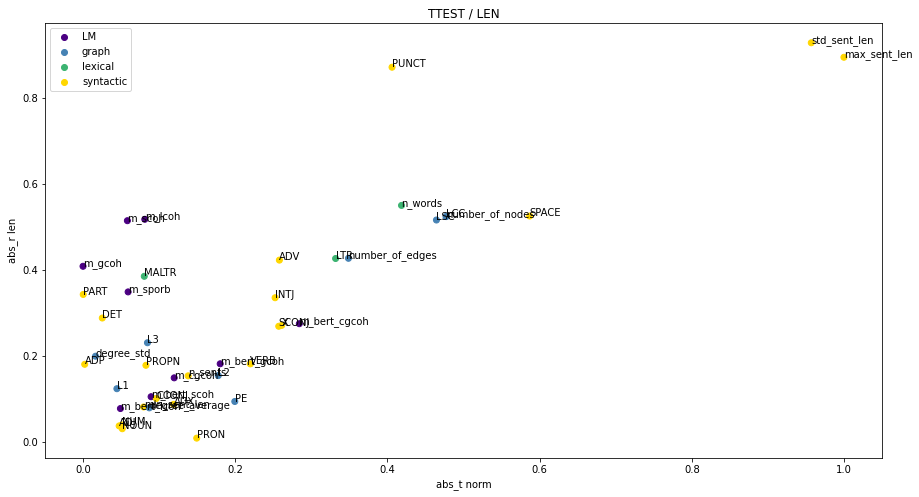

In [107]:
y = corr_len['abs_r']
z = tt_norm

n = [x[-1] for x in tt_norm.index]
c_map = {'LM': 0, 'graph': 1, 'lexical': 2, 'syntactic': 3}
c = [c_map[label[0]] for label in tt_norm.index]

plt.rcParams["figure.figsize"] = (15,8)
scatter_annotate(z, y, n, 'abs_t norm', 'abs_r len', 'TTEST / LEN', c=c)

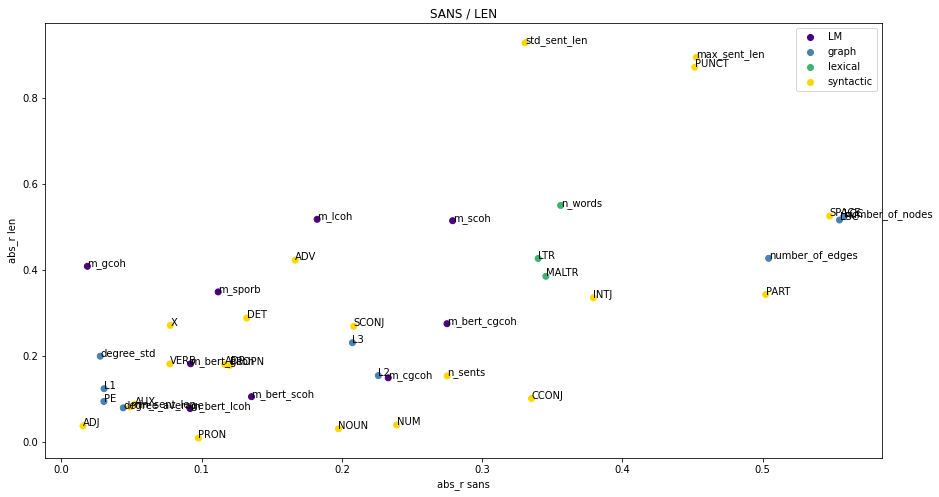

In [108]:
y = corr_len['abs_r']
z = combined_corr['sans_total', 'abs_r']

scatter_annotate(z, y, n, 'abs_r sans', 'abs_r len', 'SANS / LEN', c)

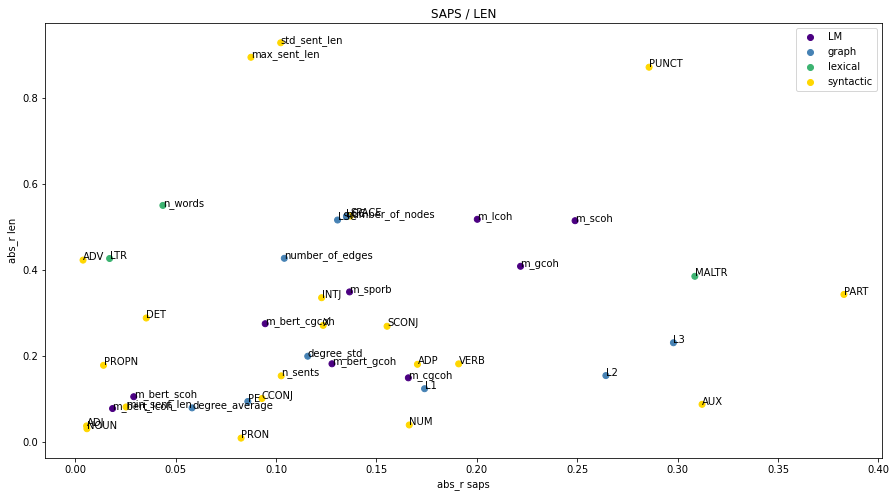

In [109]:
y = corr_len['abs_r']
z = combined_corr['saps_total', 'abs_r']

scatter_annotate(z, y, n, 'abs_r saps', 'abs_r len', 'SAPS / LEN', c)

In [110]:
# df = pd.concat([y, combined_corr['t_test', 'abs_t']], axis=1)
# df.columns = ['abs_len_corr', 'abs_ttest']

# fig = px.scatter(df, x='abs_ttest', y='abs_len_corr', text=[x[-1] for x in df.index], log_x=True, size_max=100)
# fig.update_traces(textposition='top center')
# fig.update_layout(title_text='Correlation Length Power vs T-Test Power', title_x=0.5)
# fig.show()

## Analyze correlation tables

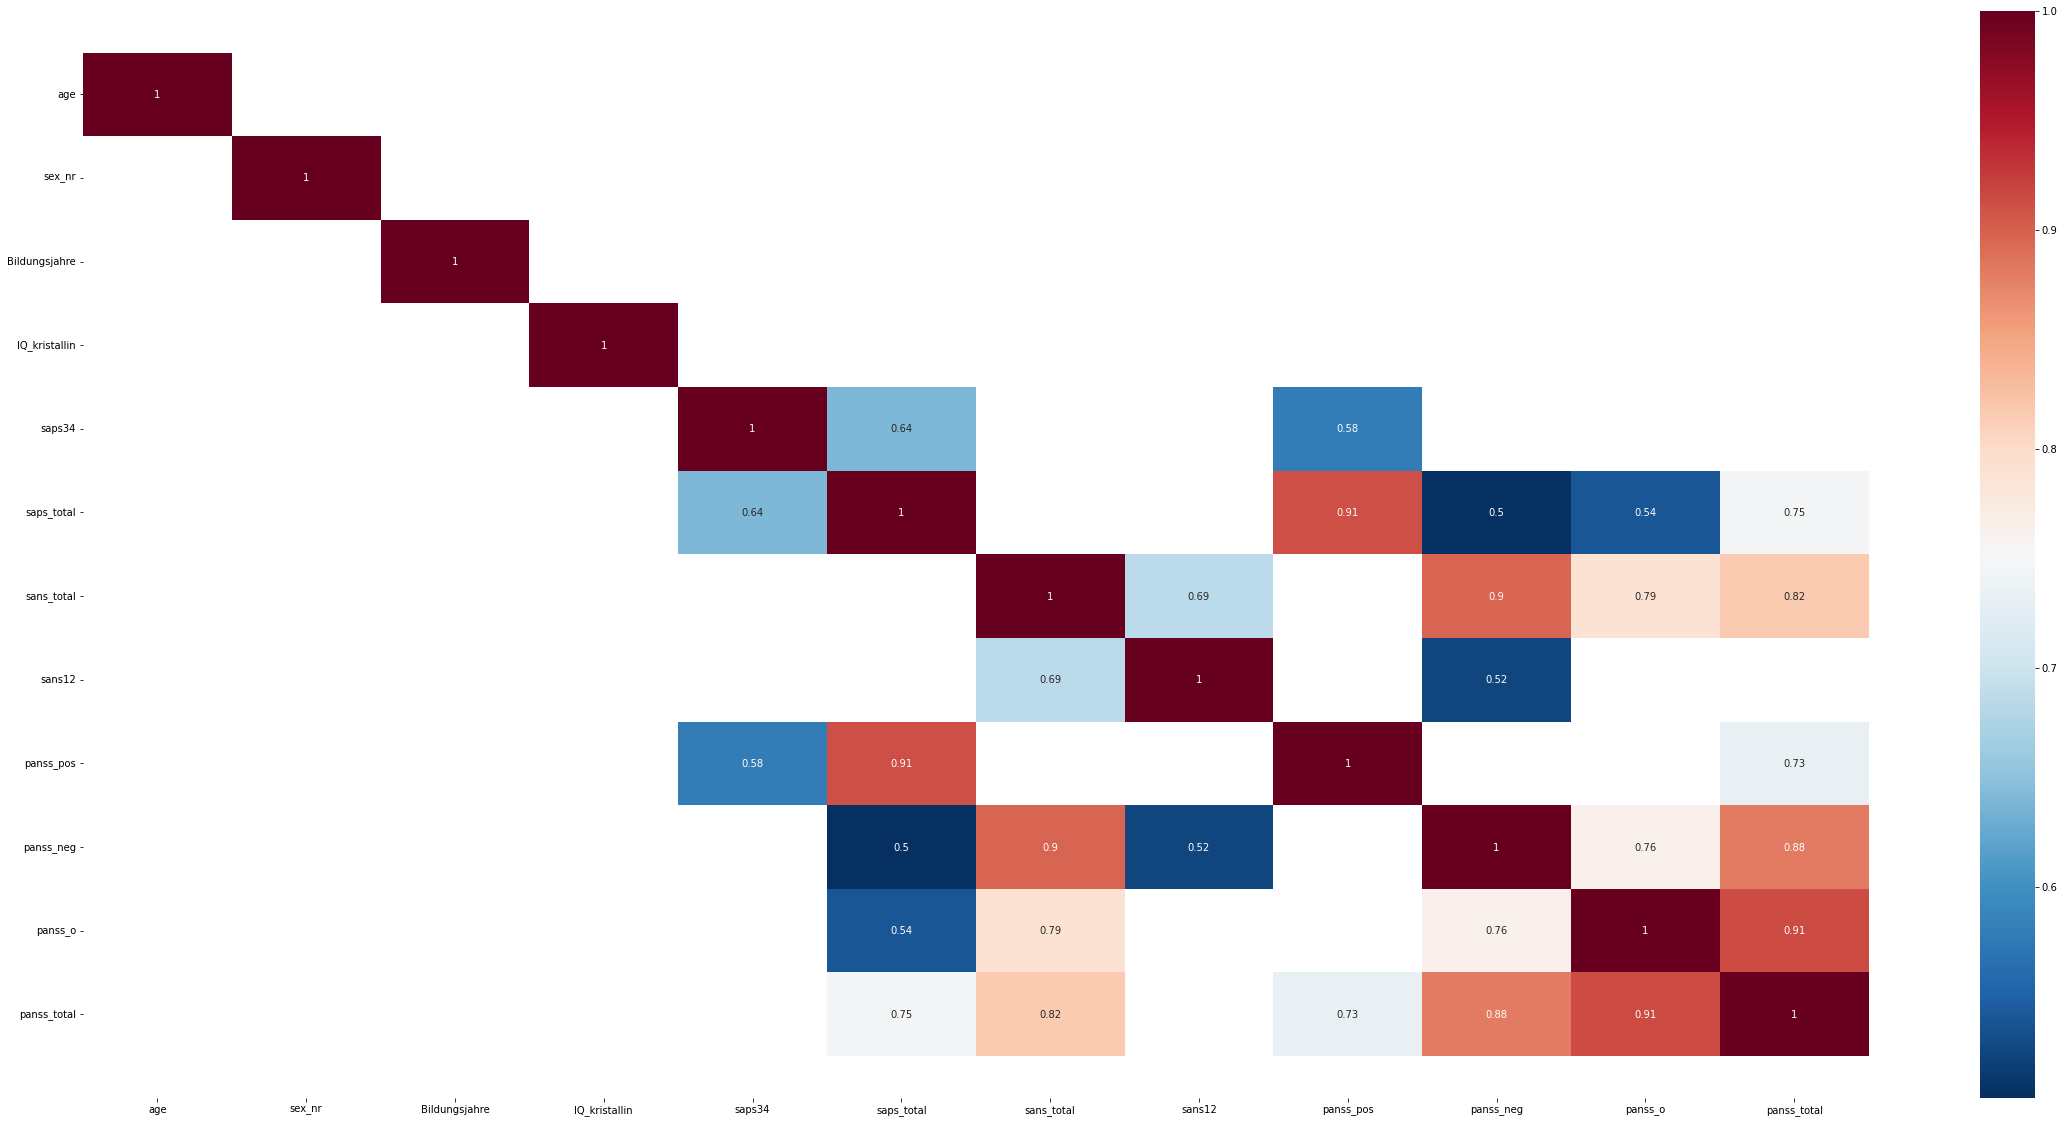

In [111]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols])
# 1. age does not correlate with IQ, education years, or psychiatric scales
# 2. IQ does not correlate with education years or psychiatric scales
# 3. saps-total correlates with saps34 and panss_pos
# 4. sans-total correlates with sans12 and panss_neg, panss_o, panss_total
# 5. panss-total correlates with panss_o, panss_neg, sans-total, panss_pos, saps-total

In [112]:
combined_data_averaged[['saps34',
                         'saps_total',
                         'sans_total',
                         'sans12',
                         'panss_pos',
                         'panss_neg',
                         'panss_o',
                         'panss_total']].describe()

,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,1.033898,16.813559,27.728814,0.915254,12.661017,16.847458,27.750847,57.259322
std,1.049895,16.697589,20.353624,1.193201,5.475998,6.025273,7.514018,16.183219
min,0.000000,0.000000,0.000000,0.000000,5.000000,8.000000,15.000000,31.000000
25%,0.000000,4.000000,13.500000,0.000000,9.000000,12.000000,23.000000,46.500000
50%,1.000000,10.000000,24.000000,0.000000,11.000000,16.000000,27.000000,53.000000
75%,2.000000,25.500000,40.000000,2.000000,15.500000,21.500000,31.000000,68.500000
max,3.000000,61.000000,79.000000,4.000000,29.000000,33.000000,48.400000,110.400000


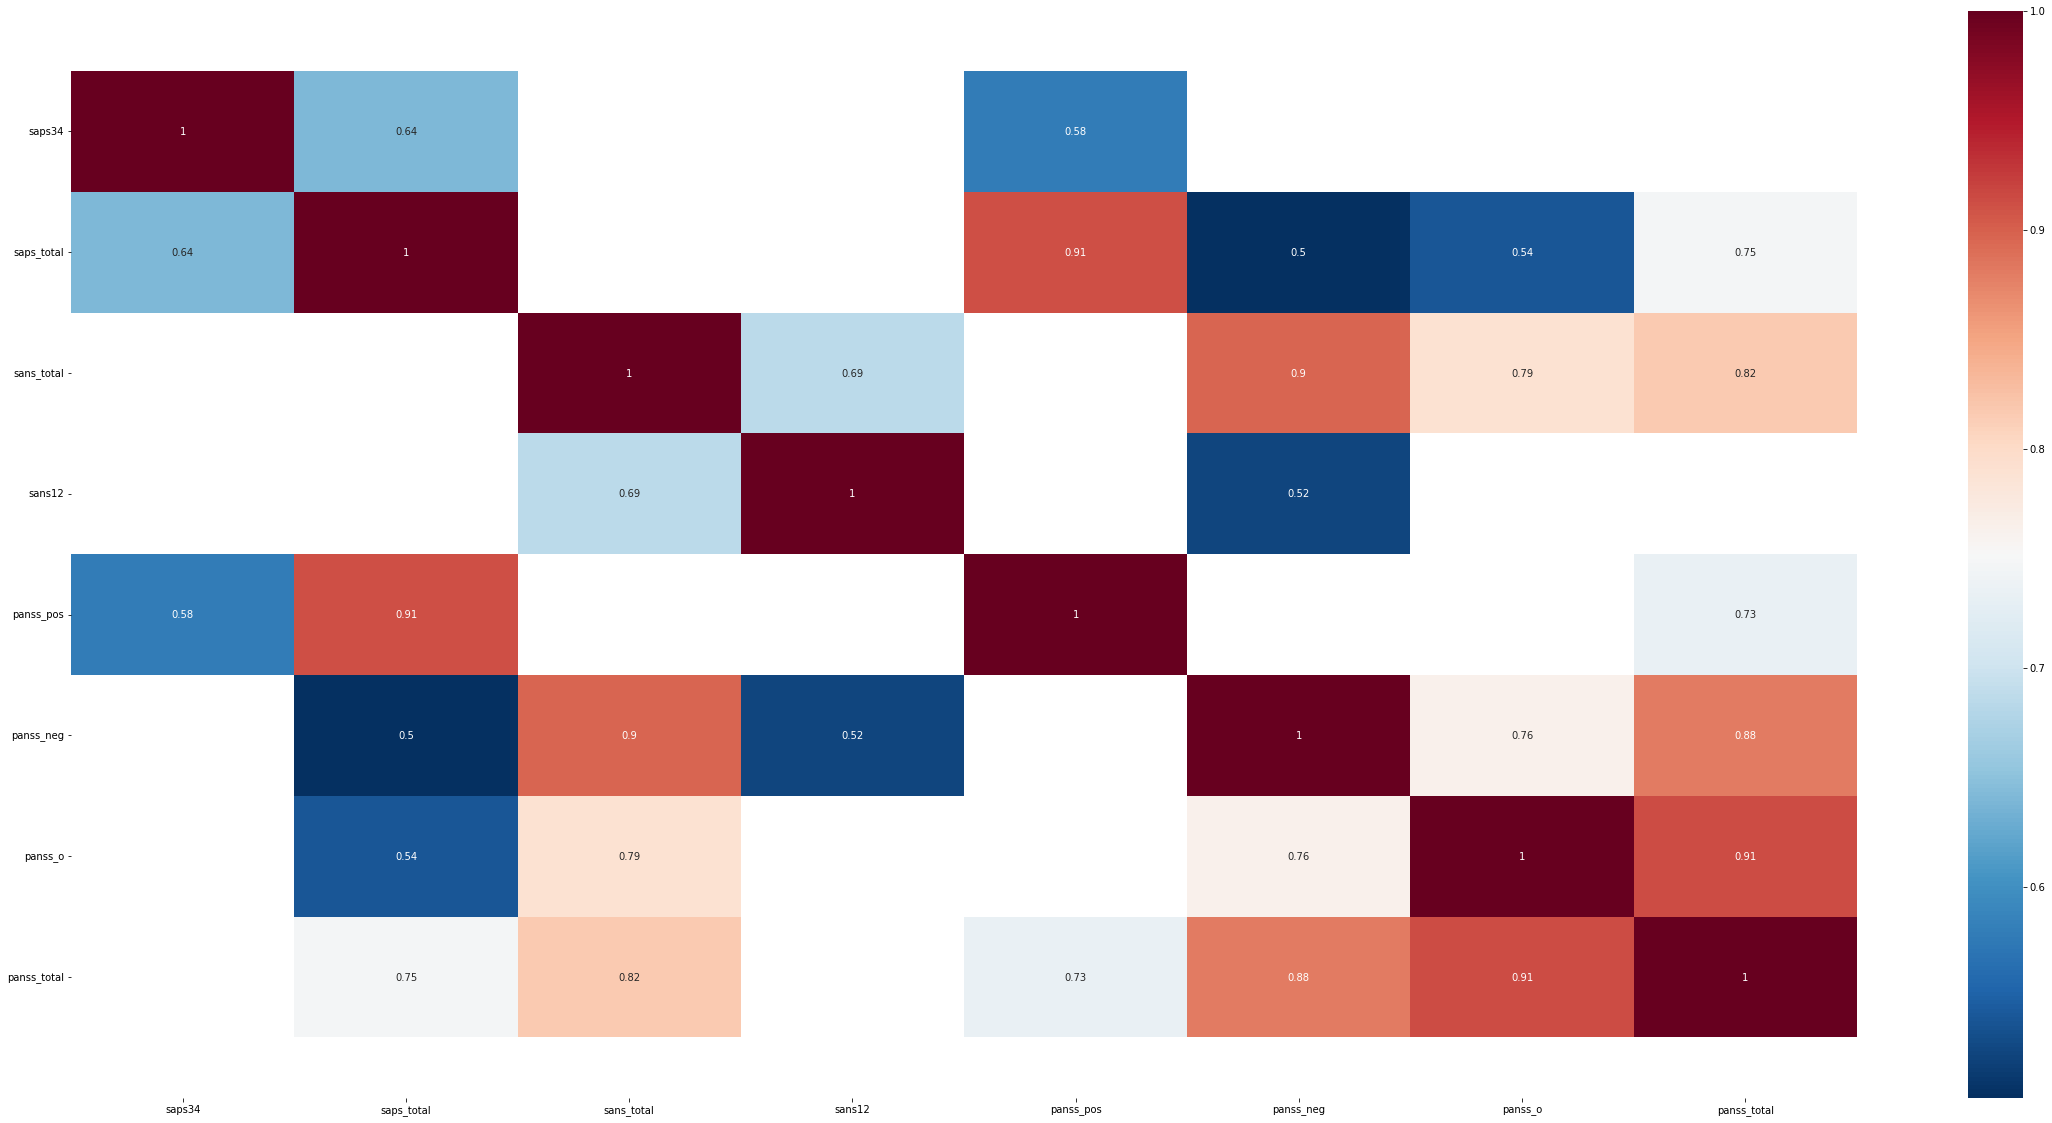

In [113]:
corr = show_corrtest_mask_corr(combined_data_averaged[['saps34',
                                                         'saps_total',
                                                         'sans_total',
                                                         'sans12',
                                                         'panss_pos',
                                                         'panss_neg',
                                                         'panss_o',
                                                         'panss_total']])

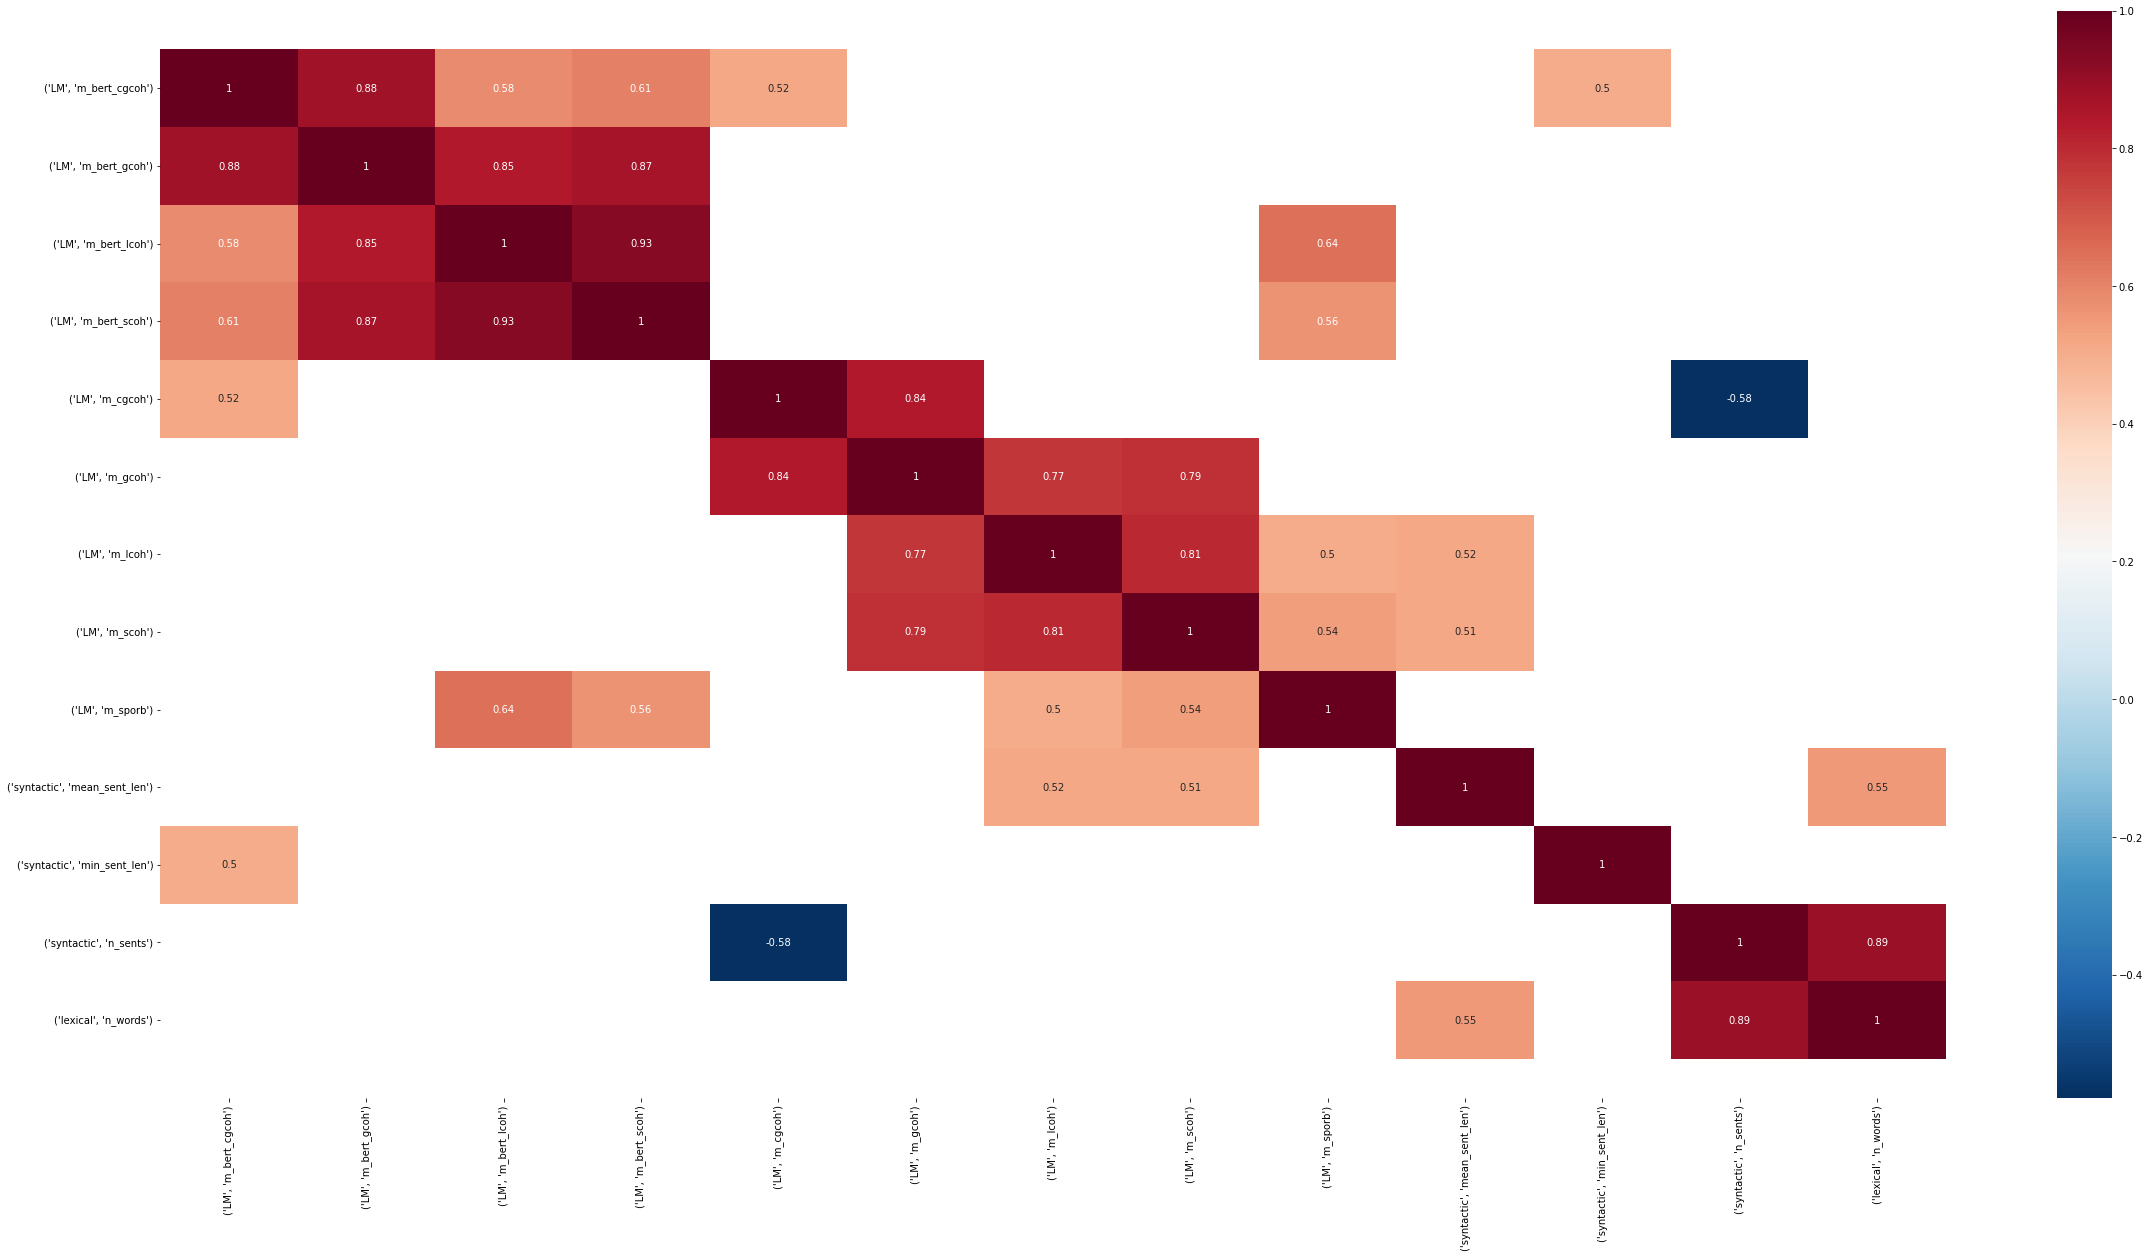

In [114]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols_LM + [('syntactic', 'mean_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]])
# 1. m_lcoh, m_gcoh, m_cgcoh, m_scoh
# 2. m_sprob, m_bert_lcoh, m_bert_gcoh, m_bert_cgcoh, m_bert_scoh
# 3. no corr with mean_sent_len or n_words, m_bert_cgcoh + min_sent_len
# 4. no corr with n_sents, m_cgcoh - n_sents

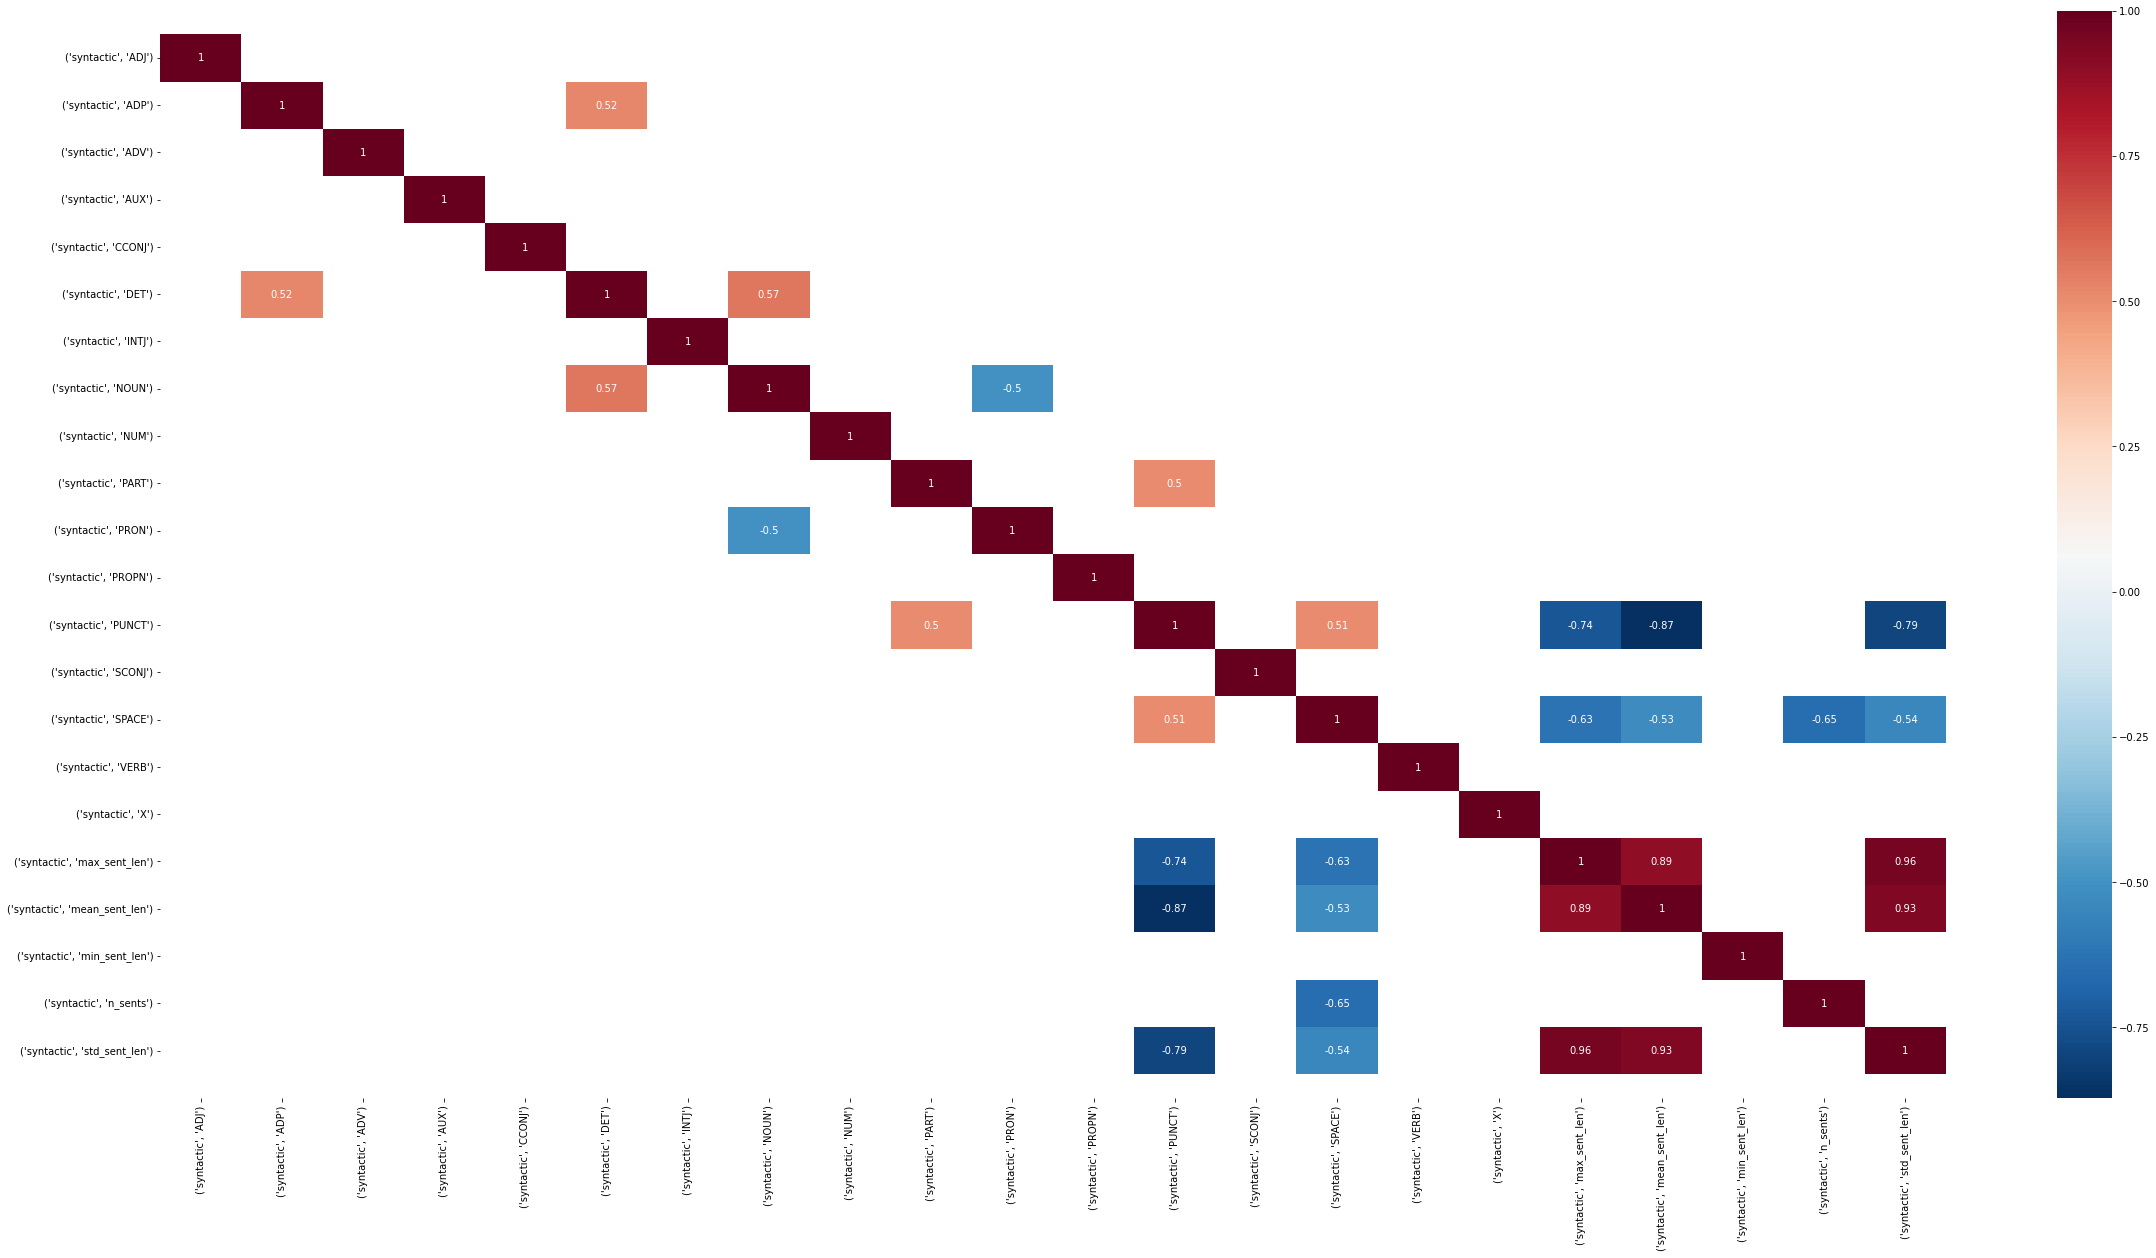

In [115]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols_synt])

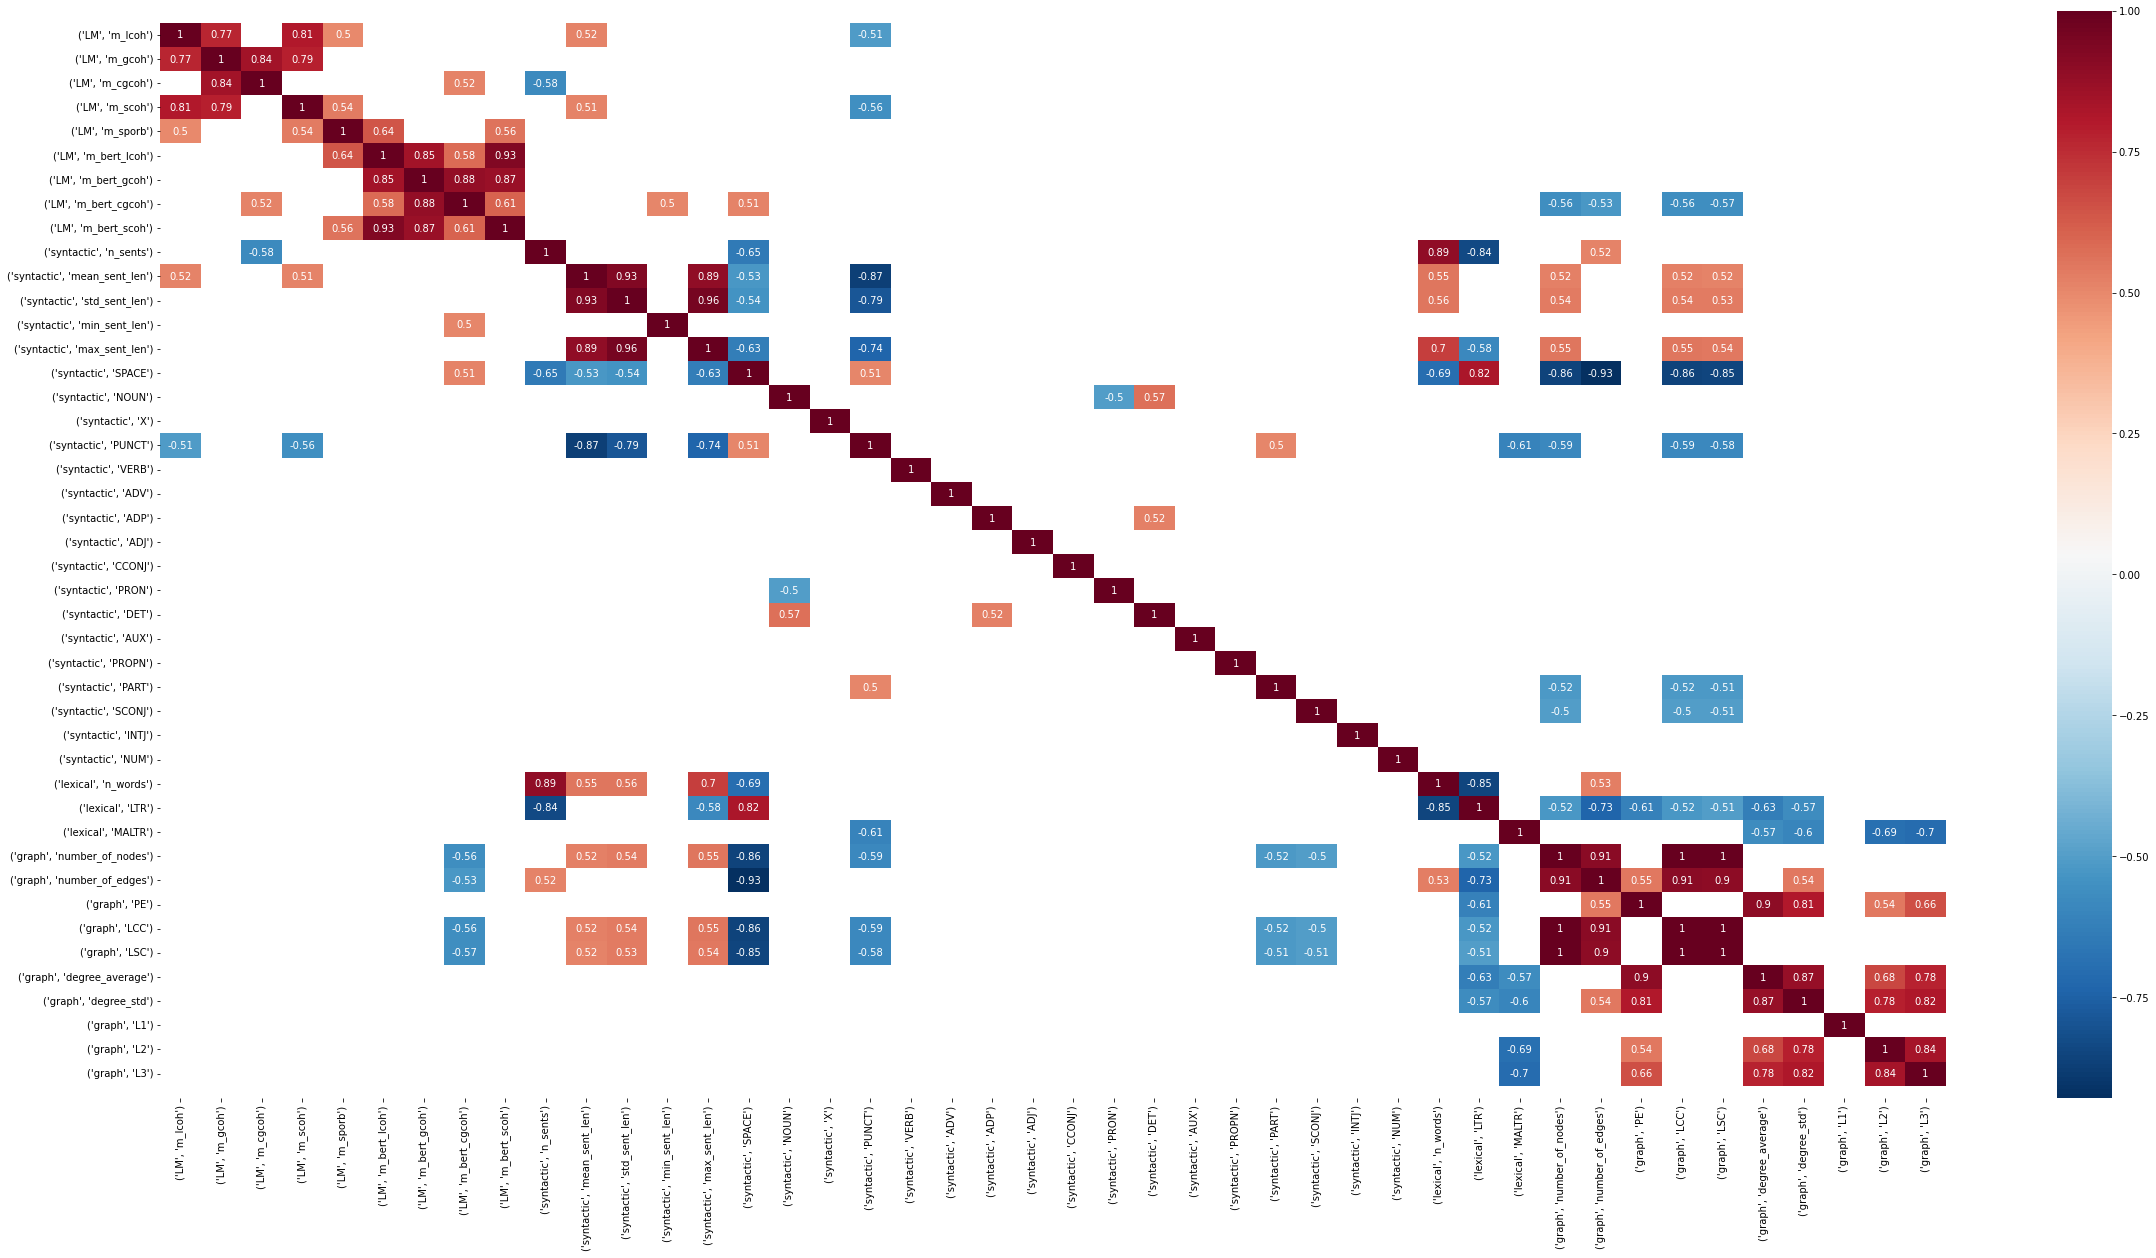

In [116]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols_av])

# Control for the effect of length

In [123]:
compute_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'PUNCT'),
                                  column_names=['punct'], target_name='sans', add_sq=False)[0]

0.20403296615493105

In [124]:
compute_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'),
                                  column_names=['sent len'], target_name='sans', add_sq=False)[0]

0.16503558980074517

In [125]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'PUNCT'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

0.043586498395295714

### bootstrap 

In [126]:
## 1 sample with replacement

## 1.1 compute_ortogonolized_r for each scale


In [125]:
scale_cols = ['saps_total',
             'sans_total',
             'panss_pos',
             'panss_neg',
             'panss_o',
             'panss_total']

In [126]:
def draw_sample_with_replacement(df, seed=None):
    if seed:
        random.seed(seed)
    length = len(df.index)
    idxs = choices(range(length), k=length)
    return df.iloc[idxs, :]

In [ ]:
dict_scales_sapmles = {scale: {metric: [] for metric in cols_av} for scale in scale_cols}
dict_scales_raws = {scale: {metric: [] for metric in cols_av} for scale in scale_cols}
for i in tqdm(range(1000)):
    sample = draw_sample_with_replacement(combined_data_averaged, seed=i)
    for scale in scale_cols:
        for col in cols_av:
            if col != ('syntactic', 'mean_sent_len'):
                r_corr = compute_ortogonolized_coefficient(sample, scale, ('syntactic', 'mean_sent_len'), col)[0]
                r_raw = compute_coefficient(sample, scale, col)[0]
                dict_scales_raws[scale][col].append(r_raw)
                dict_scales_sapmles[scale][col].append(r_corr)
            else:
                dict_scales_sapmles[scale][col].append(np.nan)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
sample_df = pd.DataFrame()
for scale in scale_cols:
    scale_metric_sd = {}
    scale_metric_md = {}
    scale_metric_mn = {}
    scale_metric_cov = {}
    scale_metric_diff = {}
    scale_metric_q25 = {}
    scale_metric_q75 = {}
    for col in cols_av:
        if col != ('syntactic', 'mean_sent_len'):
            scale_metric_sd[col] = np.std(dict_scales_sapmles[scale][col])
            scale_metric_md[col] = np.median(dict_scales_sapmles[scale][col])
            scale_metric_mn[col] = np.mean(dict_scales_sapmles[scale][col])
            scale_metric_q25[col] = np.quantile(dict_scales_sapmles[scale][col], 0.25)
            scale_metric_q75[col] = np.quantile(dict_scales_sapmles[scale][col], 0.75)
            scale_metric_cov[col] = np.std(dict_scales_sapmles[scale][col]) / np.mean(dict_scales_sapmles[scale][col])
            scale_metric_diff[col] = np.mean(dict_scales_sapmles[scale][col]) / np.mean(dict_scales_raws[scale][col])
            
    sample_df[(scale, 'md')] = pd.Series(scale_metric_md)
    sample_df[(scale, 'mn')] = pd.Series(scale_metric_mn)
    sample_df[(scale, 'sd')] = pd.Series(scale_metric_sd)
    sample_df[(scale, 'cov')] = pd.Series(scale_metric_cov)
    sample_df[(scale, 'dif')] = pd.Series(scale_metric_diff)
    sample_df[(scale, 'q25')] = pd.Series(scale_metric_q25)
    sample_df[(scale, 'q75')] = pd.Series(scale_metric_q75)

In [ ]:
sample_df

In [ ]:
sample_df.columns = pd.MultiIndex.from_tuples(sample_df.columns, names=('scale', 'res'))

In [ ]:
ex_df = sample_df.loc['LM', 'sans_total'].drop(index='m_sporb')
ex_df

In [ ]:
ex_df['model'] = ['bert' if 'bert' in x else 'w2v' for x in ex_df.index]
ex_df['metric'] = [x.split('_')[-1] for x in ex_df.index]

In [ ]:
sns.set_theme(style="whitegrid")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=ex_df, x="model", y="md", hue="metric",
    capsize=.2,  # errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [ ]:
sample_df.columns = pd.MultiIndex.from_tuples(sample_df.columns, names=('scale', 'res'))
styler = pd.io.formats.style.Styler(sample_df, precision = 4)
styler.background_gradient(axis=0, cmap='Reds')

In [ ]:
sns.histplot(dict_scales_sapmles['sans_total'][('syntactic', 'PUNCT')], bins=30);

In [ ]:
sns.histplot(dict_scales_sapmles['sans_total'][('LM', 'm_cgcoh')], bins=30);

In [ ]:
sns.histplot(dict_scales_sapmles['sans_total'][('LM', 'm_bert_cgcoh')], bins=30);

### original

In [ ]:
plt.scatter(combined_data_averaged[('syntactic', 'mean_sent_len')], combined_data_averaged[('syntactic', 'PUNCT')]);

In [ ]:
ex_df = combined_data_averaged[combined_data_averaged[('syntactic', 'mean_sent_len')] > 5]
draw_corrected_scatter(ex_df, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'PUNCT'),
                      column_names=['sent len', 'punct'], target_name='sans')

In [ ]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'PUNCT'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

In [ ]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

In [ ]:
draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'),
                      column_names=['sent len', 'm_cgcoh'], target_name='sans')

In [ ]:
draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'NUM'),
                      column_names=['sent len', 'num'], target_name='sans')

In [ ]:
draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('graph', 'number_of_edges'),
                      column_names=['sent len', 'NE'], target_name='sans')

In [ ]:
draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('graph', 'number_of_nodes'),
                      column_names=['sent len', 'NN'], target_name='sans')

In [ ]:
draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('lexical', 'MALTR'),
                      column_names=['sent len', 'maltr'], target_name='sans')

In [ ]:
draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'),
                      column_names=['sent len', 'm_cgcoh'], target_name='sans')

In [ ]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('sans_total', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [425]:
# cols_dict = {}
# for col in cols_av:
#     cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), col, add_sq=True)[0]
# combined_corr.insert(1, ('sans_total', 'r_corrected_sq_for_mean_len'), pd.Series(cols_dict)) 

In [ ]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'saps_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('saps_total', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [ ]:
# cols_dict = {}
# for col in cols_av:
#     cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'saps_total', ('syntactic', 'mean_sent_len'), col, add_sq=True)[0]
# combined_corr.insert(1, ('saps_total', 'r_corrected_sq_for_mean_len'), pd.Series(cols_dict)) 

In [ ]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'panss_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('panss', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [ ]:
# cols_dict = {}
# for col in cols_av:
#     cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'panss_total', ('syntactic', 'mean_sent_len'), col, add_sq=True)[0]
# combined_corr.insert(1, ('panss', 'r_corrected_sq_for_mean_len'), pd.Series(cols_dict)) 

In [ ]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_logit(combined_data_averaged, 'group', ('syntactic', 'mean_sent_len'), col)
combined_corr.insert(1, ('t_test', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [ ]:
t_p_n_corr_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'r_corrected_for_mean_len')].rank(ascending=False) for scale in ['sans_total', 'saps_total']], axis=1).mean(axis=1)
combined_corr.insert(1, ('mean', 'tpn_rank_corr'), t_p_n_corr_rank) 
combined_corr.insert(2, ('mean', 'tpn_rank_corr_abs'), t_p_n_corr_rank.rank()) 

In [ ]:
combined_corr.sort_values(('mean', 'tpn_rank_corr'), ascending=True).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

In [ ]:
def get_ranking_difference(df, col_initial, col_final):
    return df[col_final].rank() - df[col_initial].rank()

In [ ]:
rank_diff = pd.DataFrame()
rank_diff[('panss', 'rank_change')] = get_ranking_difference(combined_corr, ('panss', 'abs_r'), ('panss', 'r_corrected_for_mean_len'))
rank_diff[('panss', 'corrected_rank')] = combined_corr[('panss', 'r_corrected_for_mean_len')].rank()
rank_diff[('panss', 'corrected_r')] = combined_corr[('panss', 'r_corrected_for_mean_len')]


rank_diff[('sans', 'rank_change')] = get_ranking_difference(combined_corr, ('sans_total', 'abs_r'), ('sans_total', 'r_corrected_for_mean_len'))
rank_diff[('sans', 'corrected_rank')] = combined_corr[('sans_total', 'r_corrected_for_mean_len')].rank()
rank_diff[('sans', 'corrected_r')] = combined_corr[('sans_total', 'r_corrected_for_mean_len')]

rank_diff[('saps', 'rank_change')] = get_ranking_difference(combined_corr, ('saps_total', 'abs_r'), ('saps_total', 'r_corrected_for_mean_len'))
rank_diff[('saps', 'corrected_rank')] = combined_corr[('saps_total', 'r_corrected_for_mean_len')].rank()
rank_diff[('saps', 'corrected_r')] = combined_corr[('saps_total', 'r_corrected_for_mean_len')]

rank_diff[('t_test', 'rank_change')] = get_ranking_difference(combined_corr, ('t_test', 'abs_t'), ('t_test', 'r_corrected_for_mean_len'))
rank_diff[('t_test', 'corrected_rank')] = combined_corr[('t_test', 'r_corrected_for_mean_len')].rank()
rank_diff[('t_test', 'corrected_r')] = combined_corr[('t_test', 'r_corrected_for_mean_len')]
rank_diff[('t_test', 'val')] = combined_corr[('t_test', 'abs_t')]

rank_diff.columns = pd.MultiIndex.from_tuples(rank_diff.columns, names=('scale', 'res'))
rank_diff = rank_diff.apply(pd.to_numeric)

In [ ]:
rank_diff.style.background_gradient(axis=0, cmap='Reds')

In [ ]:
n = [label[1] for label in rank_diff.index]
c_map = {'LM': 0, 'graph': 1, 'lexical': 2, 'syntactic': 3}
c = [c_map[label[0]] for label in rank_diff.index]

In [ ]:
def plot_res_corr(x, y, n, x_name, y_name, title, c=None):
    r = stats.pearsonr(x, y).statistic
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    ypred = model.predict(X)
    plt.plot(x, ypred, color='red', label=f'coef: {model.params[1]:.2f} \ncorr: {r:.2f}')

    plt.gca().add_artist(plt.legend(loc=9))

    scatter_annotate(x, y, n, x_name, y_name, title, c=c)

In [ ]:
x = rank_diff[('panss', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'panss r', 'ttest pseudo r', 'PANSS / TTEST', c)

In [ ]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'ttest pseudo r', 'SANS / TTEST', c)

In [ ]:
x = rank_diff[('saps', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'saps r', 'ttest pseudo r', 'SAPS / TTEST', c)

In [ ]:
x = rank_diff[('saps', 'corrected_r')]
y = rank_diff[('panss', 'corrected_r')]

plot_res_corr(x, y, n, 'saps r', 'panss r', 'SAPS / PANSS', c)

In [ ]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('saps', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'saps r', 'SANS / SAPS', c)

In [ ]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('panss', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'panss r', 'SANS / PANSS', c)

In [ ]:
x = rank_diff[('sans', 'corrected_rank')]
y = rank_diff[('panss', 'corrected_rank')]

plot_res_corr(x, y, n, 'sans rank', 'panss rank', 'SANS / PANSS', c)